In [338]:
from utils import *
tic()

# use 4 decimals for tables
pd.options.display.float_format = '{:,.4f}'.format

Remise électronique sur ZoneCours au plus tard le **22 février à 23h55** de:

* Ce Jupyter notebook (.ipynb) en guise de rapport, une fois les réponses ajoutées. 
* **Tous** les fichiers *.py* nécessaires pour l'exécution du notebook

Le rapport **doit**:

* être en format .ipynb (des points seront enlevés pour tout autre format).
* inclure le numéro de matricule de tous les membres de l'équipe dans la première cellule (i.e. remplacez ces consignes)
* répondre aux questions et discuter des résultats à l'aide de tables, graphiques, et cellules markdown

Barème:

* **40%** Exactitude des résultats
* **25%** Discussions complètes et **concises** (cellules ``markdown'')
* **20%** Concision du notebook (.ipynb avec minimum de code) et clarté des graphiques
* **15%** Clarté du code (.py)

Dans les tables, présentez 4 décimales après le point.

# Question 1

Une action ne versant pas de dividende cote présentement à 100. Le taux sans risque à 1 mois est de 5%. Vous observez sur le marché les prix suivants pour des puts européens venant à maturité dans 1 mois:

In [339]:
info = get_info()
info

,Strike,Put
0,80.0000,0.1900
1,90.0000,0.6907
2,97.5000,1.6529
3,102.5000,3.3409
4,110.0000,9.8399
5,120.0000,19.5805


Quelles sont les volatilités implicites ('IV') de ces puts? Tracez le graphe des ces IV en fonction de $K/S$ et discutez brièvement.

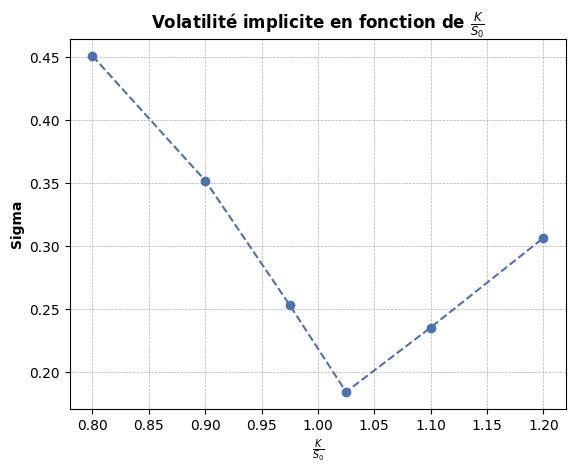

,Strike,Put,Implied vol.
0,80.0000,0.1900,0.4512
1,90.0000,0.6907,0.3523
2,97.5000,1.6529,0.2534
3,102.5000,3.3409,0.1845
4,110.0000,9.8399,0.2356
5,120.0000,19.5805,0.3067


In [340]:
# Données du problème
S_0 = 100
r_f = 0.05
T   = 1/12

# Calcul des volatilités implicites 
sigma = [implied_volatility(opt_price = P, S = S_0,  K = K, r = r_f, y = 0, T = T, is_call   = False)[0] for K, P in info.values]
info['Implied vol.'] = sigma

plot_implied_vol(S_0, info)
info

Le graphique précédent montre bien le 'volatility smile' pour les puts sur notre actif sous-jacent. En effet, la volatilité implicite augmente pour pour les puts qui sont plus loin dans ou hors de la monnaie. 

Il est d'ailleurs intéressant de remarquer que le 'smile' n'a pas une forme symétrique. En effet, la pente de la courbe de la volatilité implicite pour les puts hors de la monnaie (à gauche de $K/S=1$) est plus grande que la pente pour les puts dans la monnaie. Une des explications possibles pour ce phénomène vient du fait que les puts hors de la monnaie ont plus de valeurs, car, ils offrent aux investisseurs une forme d'assurance ou de protection contre une baisse du prix du sous-jacent.

# Question 2

Vous vous intéressez à ces options parce que vous avez, d'autre part, 
émis des produits structurés contenant des puts de même strikes, mais permettant un exercice à tout moment d'ici la maturité. Pour chacun de ces strike, vous désirez donc utiliser un arbre CRR afin de valoriser l'option américaine correspondante.

En premier lieu, vous désirez donc étudier la convergence de votre arbre vers le prix BMS pour les européennes observées sur le marché. Pour des valeurs de $N$ allant de 2 à 100 (`range(2,101)`), tracer, dans une figure 
`
    fig, axes = plt.subplots(3, 2, figsize=(15,20))
`
avec une sous-figure par strike,

* Le prix CRR obtenu pour chaque $N$
* Une ligne horizontale traitillée au prix de marché
* Deux ligne horizontales pointillées à $\pm$1 bp du prix de marché

Discutez brièvement de la qualité de la convergence.

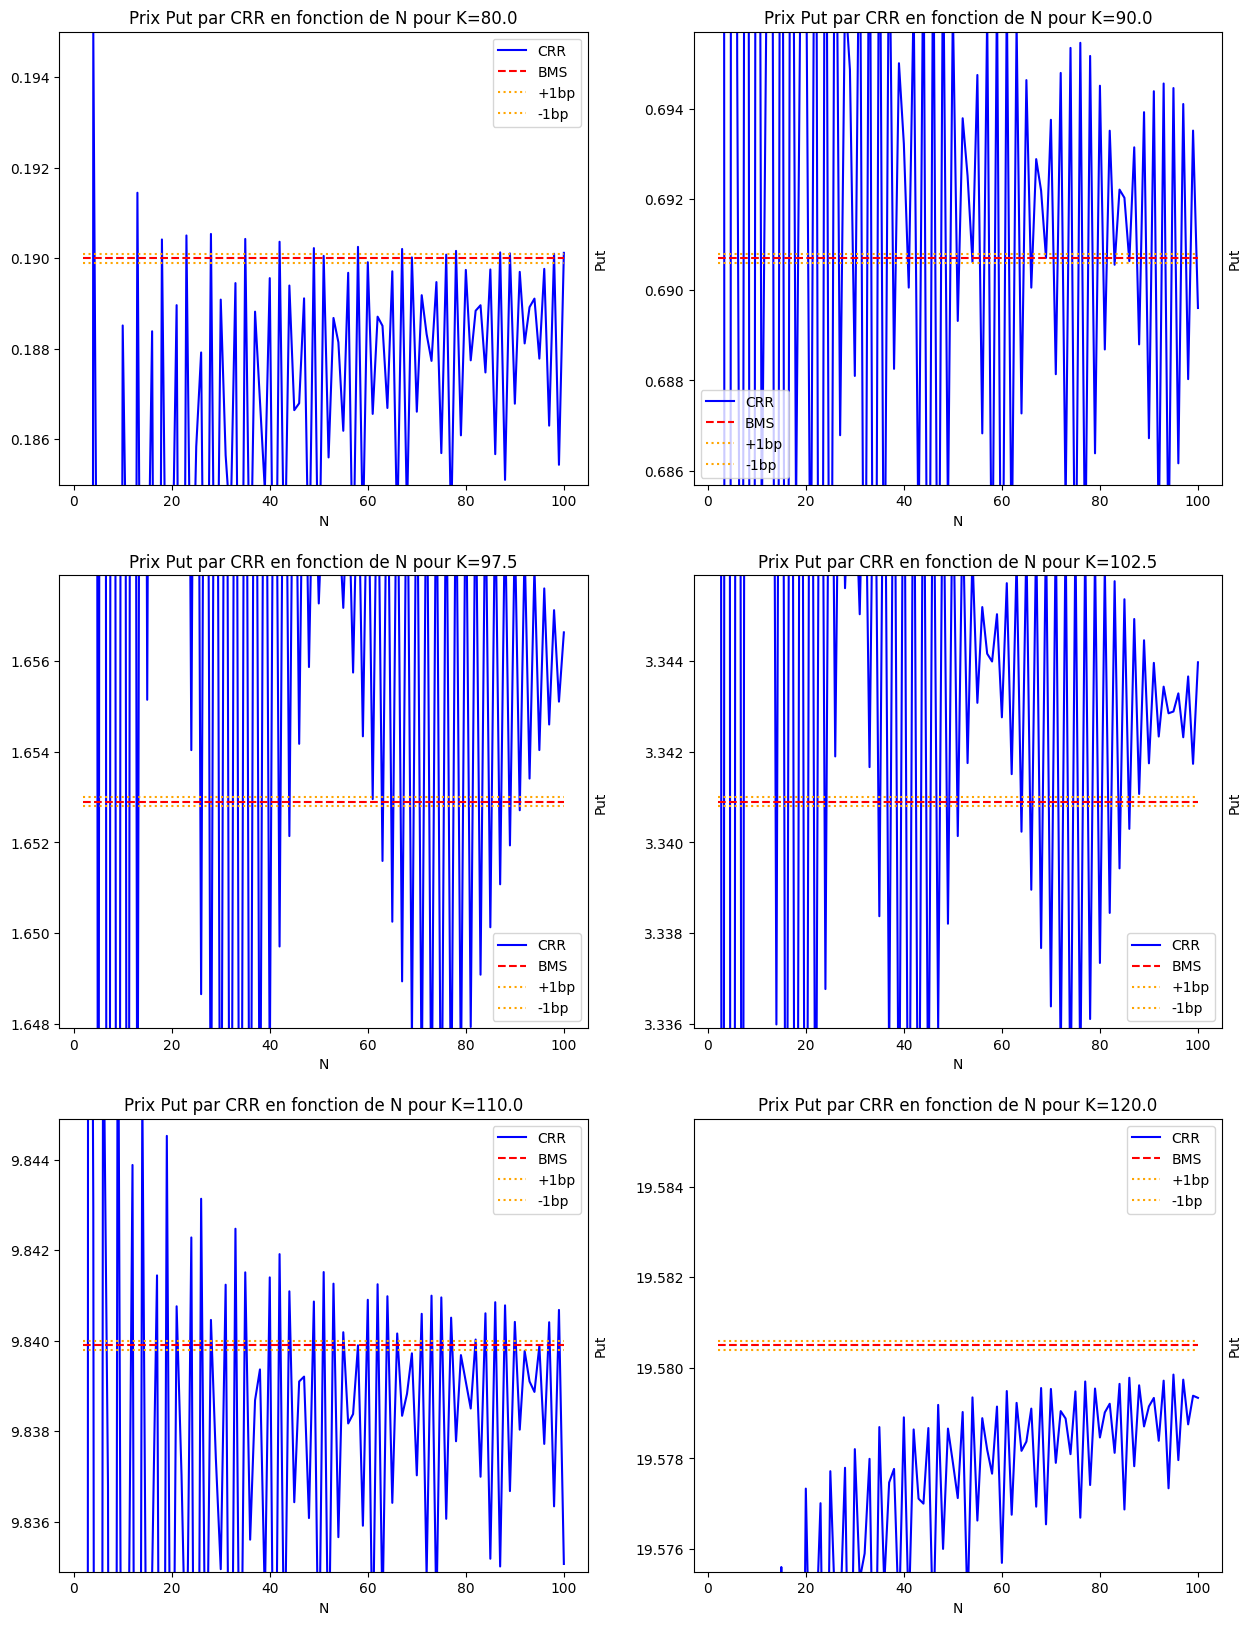

In [341]:
N_Range = np.arange(2, 101)
df_CRR  = CRR_tree_df(S = S_0,  K = info['Strike'],  T = T,  r = r_f, sigma = info['Implied vol.'], Type = 0, N_Range = N_Range)

plot_CRR_tree(df_CRR_list = [[df_CRR, 'CRR', 'b']], N_Range=N_Range, zoom_factor=50)

Il est clair que le nombre de pas de temps n'est pas assez élevé afin d'avoir une convergence acceptable ($\pm$ 1bp). En effet, même s'il semble y avoir une tendance oscillatoire qui veut se rapprocher du prix BMS, la différence de prix entre 2 itérations reste énorme pour l'arbre avec le nombre de pas données.

# Question 3

Répétez la figure ci-haut, en vous concentrant sur les pas $N = range(400, 501)$. 
Ajoutez aussi, pour chaque strike, une courbe raportant la valeur obtenu à $N$ avec l'arbre CRR ajusté à l'aide de la correction de Broadie et Detemple. Comparez les deux méthodes. En particulier, soulignez l'avantage de l'ajustement quand viendra le temps de choisir un nombre de pas de temps respectant une tolérance de $\pm$ 1bp.

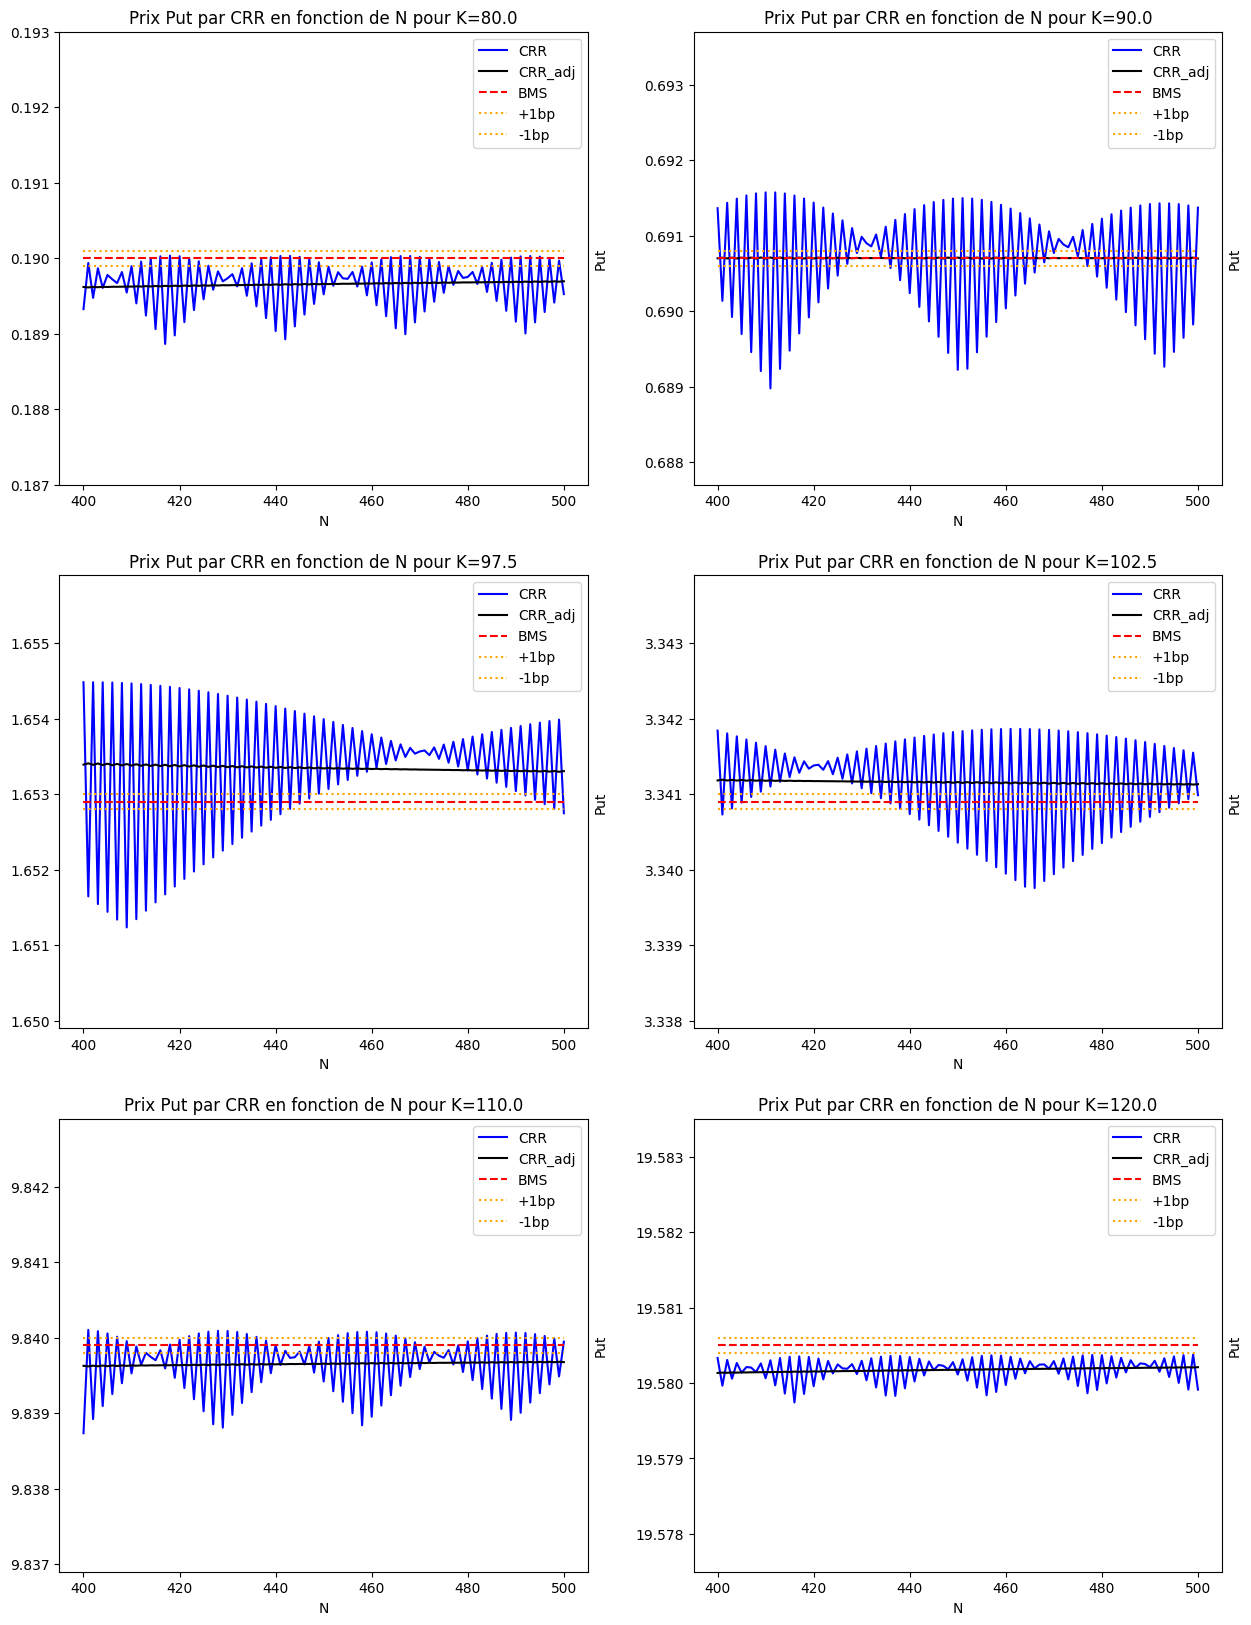

In [342]:
N_Range   = np.arange(400, 501)
df_CRR    = CRR_tree_df(S     = S_0, K = info['Strike'], T = T, r = r_f, sigma = info['Implied vol.'], Type = 0, N_Range = N_Range)
df_CRR_BD = CRR_tree_BD_df(S  = S_0, K = info['Strike'], T = T, r = r_f, sigma = info['Implied vol.'], Type = 0, N_Range = N_Range)

plot_CRR_tree(df_CRR_list = [[df_CRR, 'CRR', 'b'],[df_CRR_BD, 'CRR_adj', 'k']], N_Range = N_Range, zoom_factor=30)

On remarque que même avec plus de pas de temps, la méthode CRR classique semble converger de façon oscillatoire vers le prix BMS. Par contre, lorsque la correction de Broadie et Detemple est applliquée, la convergence devient beaucoup plus lisse. L'avantage de ce comportement plus linéaire de la convergence avec l'arbre CRR ajusté est que, une fois la borne acceptable de convergence atteinte, le méthode ne donnera plus de prix qui sorte de cette borne. Il sera donc beaucoup plus facile de choisir un nombre de pas de temps qui repecte une tolérance puisqu'il suffira d'identifier le point où cette tolérance est atteinte. Cette technique d'identification ne fonctionnerait pas avec une covergence oscillatoire puisqu'une fois à l'intérieur de la tolérance, il serait possbile d'en ressortir.

Finalement, il est intéressant de noter que, même si la correction de Broadie et Detemple a été developpée afin d'améliorer la convergence de l'arbre CRR lors de la tarification d'options américaines, la technique fonctionne aussi pour nos puts européens. C'est logique puisque l'idée de Broadie et Detemple était d'exploiter le caractère européen du dernier pas de temps dans l'arbre binomiale pour une option américaine. Or, pour une option européenne, le caractère du dernier pas de temps est évidemment aussi européen. 

# Question 4

En utilisant maintenant que les pas $N = range(500, 3001, 100)$, n'utilisez que l'arbre avec ajustement. Tracez à nouveau une figure de convergence 3x2. Combien de pas de temps sont nécessaires pour que tous les strikes respectent une tolérance de $\pm$ 1bp?

Assurez-vous aussi, pour chaque $N$, de calculer les 3 approximations suivantes du gamma:
\begin{align}
 \Gamma_0 &= \frac{p_{uu}-2p_{ud}+p_{dd}}{\left[(u-d) S\right]^{2}},
 \\
 \Gamma_1 &= \frac{
    \frac{(p_{uu}-p_{ud})}{u^{2}S-S} 
    - \frac{(p_{ud}-p_{dd})}{S-d^{2}S}
  }{Su - Sd},
 \\
 \Gamma_2 &= \frac{
    \frac{(p_{uu}-p_{ud})}{u^{2}S-S} 
    - \frac{(p_{ud}-p_{dd})}{S-d^{2}S}
  }{\frac{1}{2}(Su^2 - Sd^2)}.
\end{align}

Produisez une nouvelle figure de convergence, cette fois vers $\Gamma_{BMS}\pm 1bp$. Discutez brièvement.

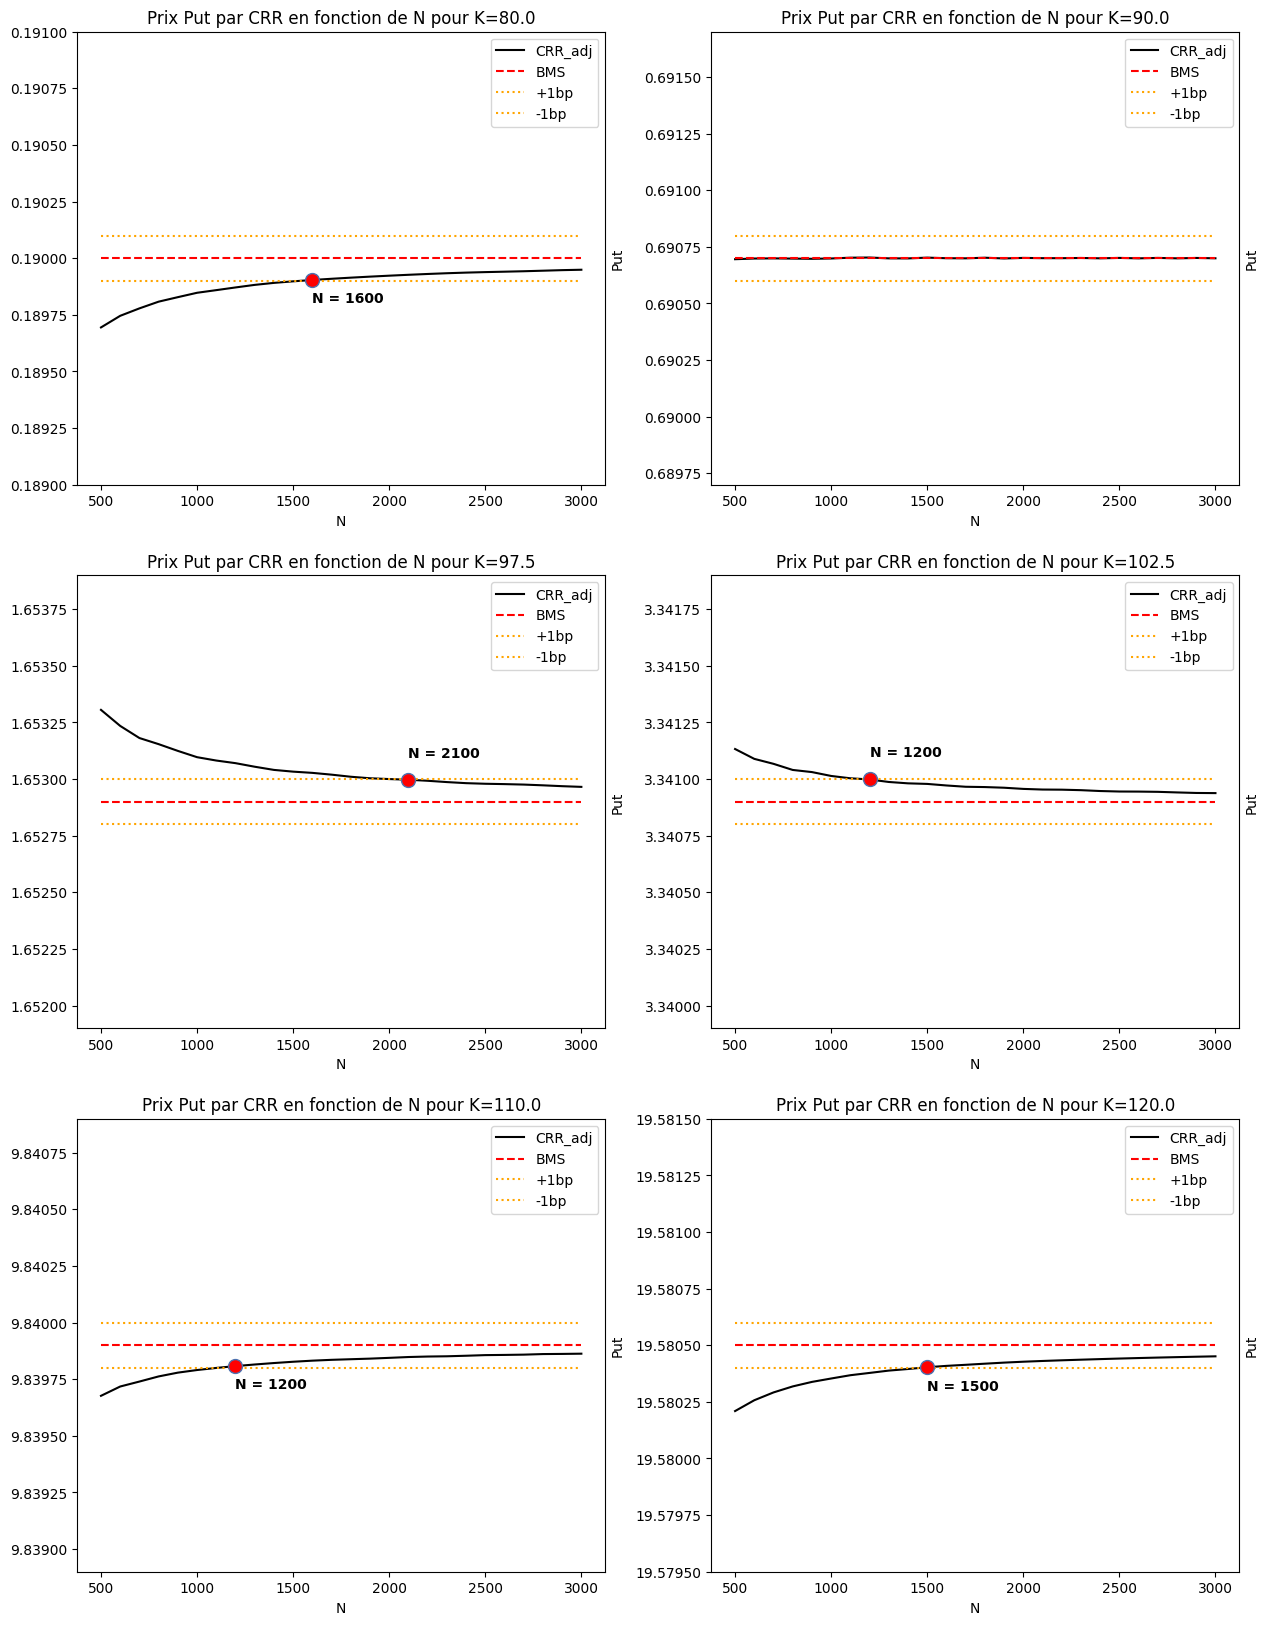

In [343]:
N_Range             = np.arange(500, 3001, 100)

gamma_bms           = [gamma(S = S_0, K = K, r = r_f, y = 0, T = T, sigma = Sig) for K,_,Sig in info.values]
df_CRR_BD, gamma_BD = CRR_tree_BD_df(S  = S_0, K = info['Strike'], T = T, r = r_f, 
                                  sigma = info['Implied vol.'], Type = 0, N_Range = N_Range, ret_gamma = True)

plot_CRR_tree(df_CRR_list = [[df_CRR_BD, 'CRR_adj', 'k']], N_Range = N_Range, zoom_factor = 10, cross = True)

En appliquant la correction de Broadie et Detemple, la convergence se fait aussi rapidement qu'avant 500 pas pour le put avec un strike à 90. C'est le put avec un strike de 97.5 qui prend le plus de temps à converger avec 2100 pas. C'est donc avec 2100 pas que tous les strikes respectent une tolérance de $\pm$ 1bp.

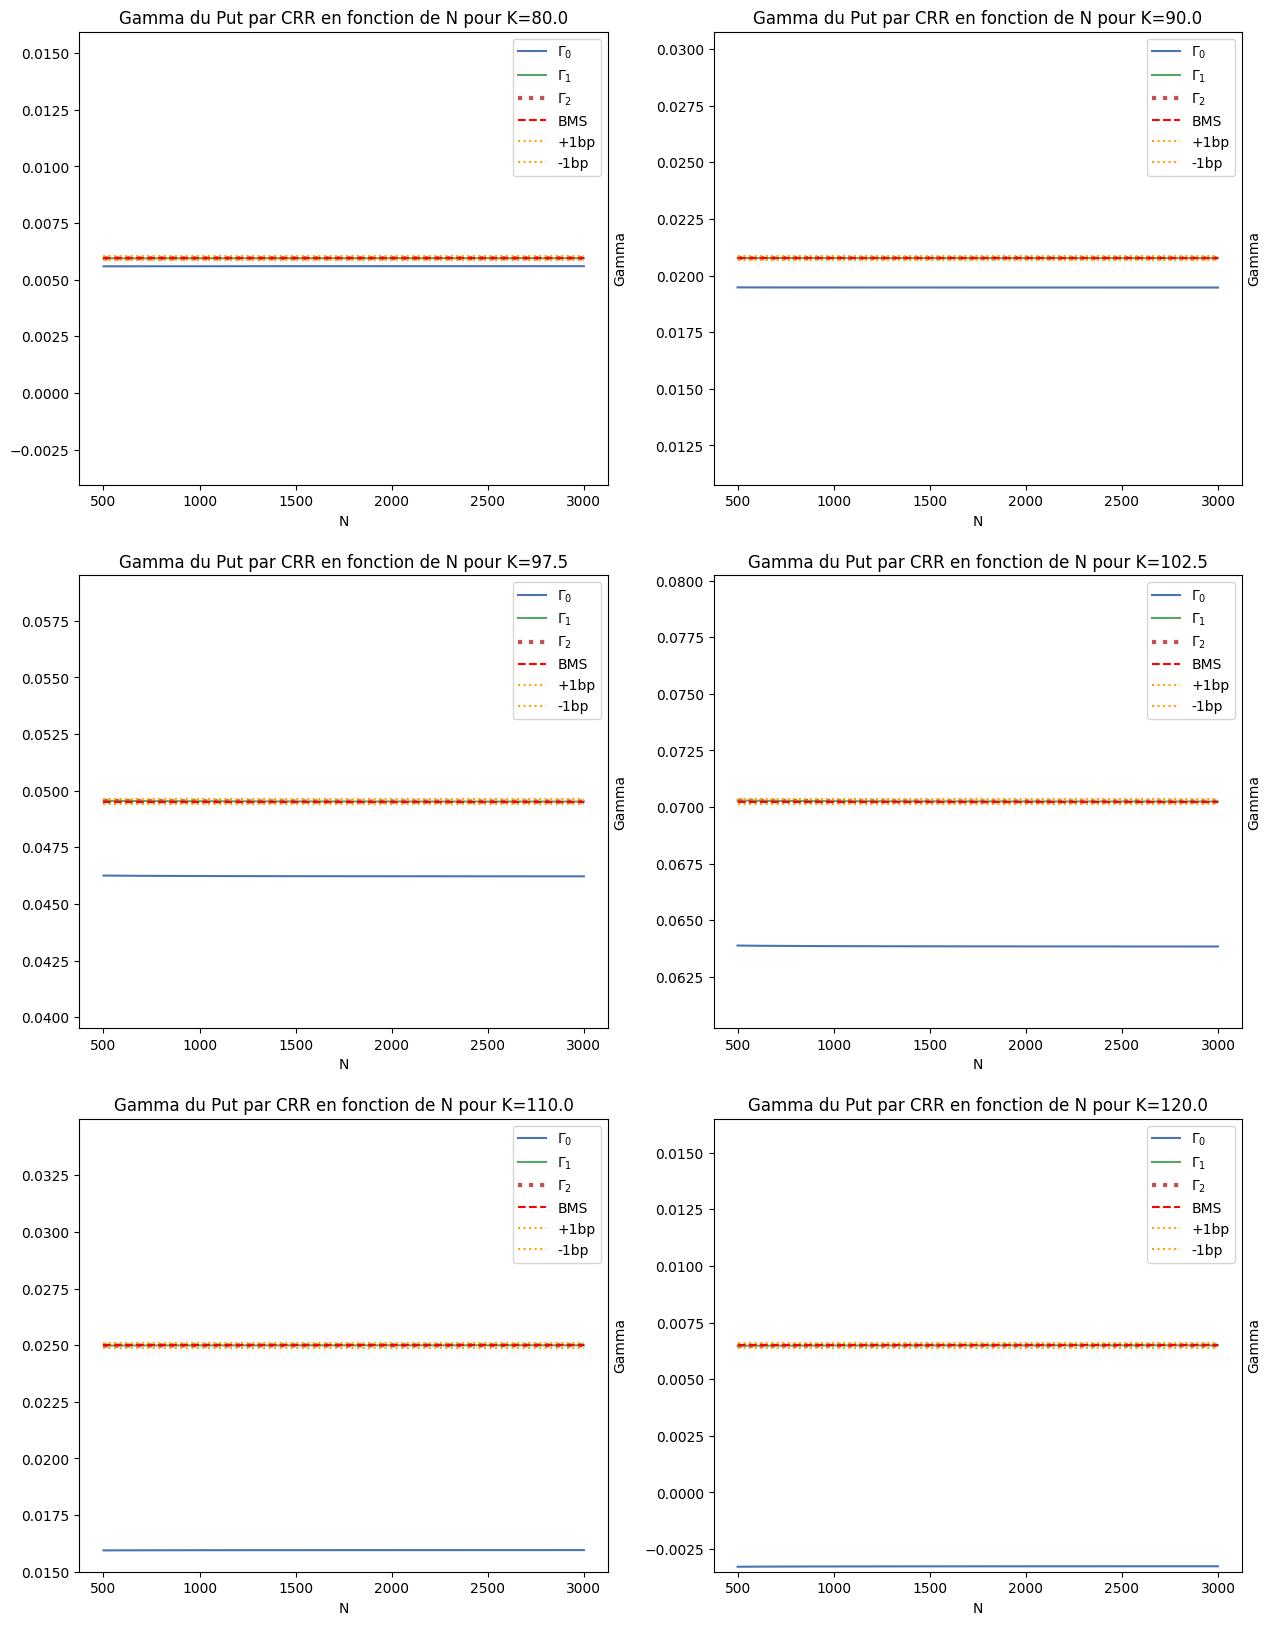

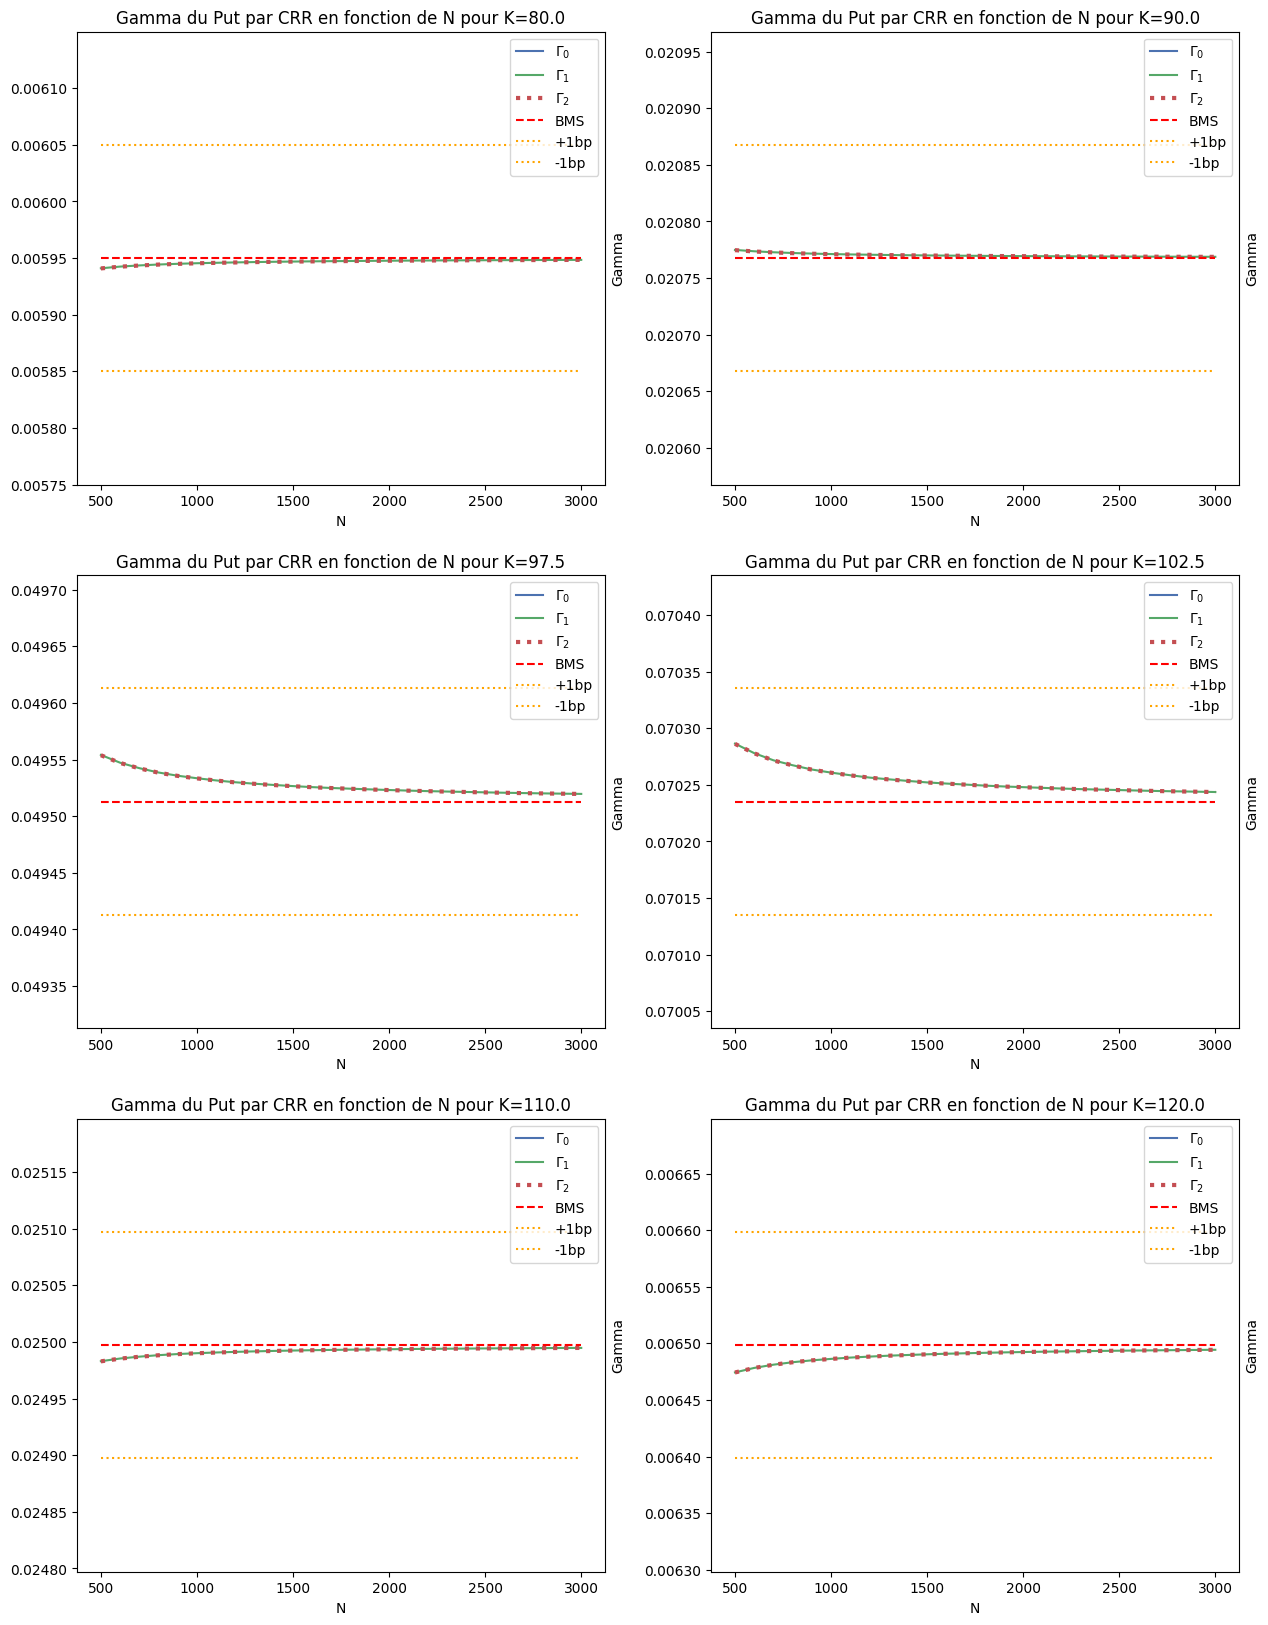

In [344]:
plot_gamma(gamma = gamma_BD, gamma_bms = gamma_bms, N_Range = N_Range, zoom_factor = 100)
plot_gamma(gamma = gamma_BD, gamma_bms = gamma_bms, N_Range = N_Range, zoom_factor = 2)

Premièrement, les 6 graphiques ont été générés 2 fois afin de pouvoir bien montrer le comportement des 3 approximations du gamma. Les premiers graphiques qui ont été générés montrent que l'approximation du $\Gamma$ par $\Gamma_0$ est mauvaise. En effet, elle donne un valeur toujours inférieur au $\Gamma_{BMS}$ et aux autres approximations, sans jamais entrer dans la tolérance de $\pm$ 1bp. Elle va même jusqu'à donner une valeur négative pour le strike de 120. Or, un $\Gamma$ négatif ne fait pas de sens. 

Pour ce qui est des deuxièmes graphiques générés, ils montrent une convergence de l'approximation par $\Gamma_1$ et $\Gamma_2$ vers $\Gamma_{BMS}$. Cette convergence se fait même plus rapidement que la convergence des valeurs des puts. Il est aussi intéressant de noter que $\Gamma_1$ et $\Gamma_2$ se comporte exactemement de la même façon.

Par ailleurs, il est logique que l'approximation par $\Gamma_1$ est plus précise que celle par $\Gamma_0$. Rappelons que $\Gamma_0$ s'obtient par la discrétisation de la dérivée seconde par rapport au sous-jacent. Quant à $\Gamma_1$, il s'obtient en le définissant comme la dérivée première du $\Delta$ par rapport au sous-jacent, où $\Delta$ s'obtient par la discrétisation de la dérivée première par rapport au sous-jacent. Bref, l'erreur commise par $\Gamma_0$ sera plus grande car l'erreur de discrétisation associée à une dérivée seconde est plus grande que l'erreur de discrétisation associée à une dérivée première.

# Question 5
Soit $N^*$ le nombre de pas de temps nécessaire à une convergence pour les 6 strikes (cf. Question 4). Ajoutez à la table dans l'énoncé de la Question 1 les colonnes suivantes:

`
colnames = ['IV','Amer','EarlyEx','Gamma_e','Gamma_a','Gamma_ex']
`

qui contiendront pour chaque strike, respectivement, la volatilité implicite (en Q1), la valeur de l'américaine, la prime associée à l'exercice anticipé et le gamma de l'européenne (BMS) et de l'américaine, et la différence entre les gammas.

Discutez.

In [345]:
# Nombre de pas nécessaire à la convergence (voir Q4)
N_star  = 2100
N_Range = np.arange(N_star, N_star + 1)

# Calcul des valeurs des puts américains et des gammas
Amer, Gamma_a = CRR_tree_BD_df(S  = S_0, K = info['Strike'], T = T, r = r_f, sigma = info['Implied vol.'], 
                                Type = 1, N_Range = N_Range, ret_gamma = True)

Euro, Gamma_e = CRR_tree_BD_df(S  = S_0, K = info['Strike'], T = T, r = r_f, sigma = info['Implied vol.'], 
                                Type = 0, N_Range = N_Range, ret_gamma = True)

# Mise en forme de de la table info
info['Amer']     = list(Amer.iloc[0])
info['EarlyEx']  = info['Amer'] - info['Put'] 
info['Gamma_e']  = [float(gamma_e['gamma_1']) for gamma_e in Gamma_e]
info['Gamma_a']  = [float(gamma_a['gamma_1']) for gamma_a in Gamma_a]
info['Gamma_ex'] = info['Gamma_a'] - info['Gamma_e']

info = info.rename(columns={'Implied vol.': 'IV'})
info


,Strike,Put,IV,Amer,EarlyEx,Gamma_e,Gamma_a,Gamma_ex
0,80.0000,0.1900,0.4512,0.1904,0.0004,0.0059,0.0060,0.0000
1,90.0000,0.6907,0.3523,0.6939,0.0032,0.0208,0.0209,0.0002
2,97.5000,1.6529,0.2534,1.6684,0.0155,0.0495,0.0504,0.0009
3,102.5000,3.3409,0.1845,3.4083,0.0674,0.0702,0.0746,0.0044
4,110.0000,9.8399,0.2356,10.0660,0.2261,0.0250,0.0296,0.0046
5,120.0000,19.5805,0.3067,20.0000,0.4195,0.0065,0.0000,-0.0065


# Question 6

L'action sous étude à, historiquement, eu une volatilité $\sigma_0 = 16\%$. Vous croyez que cette mesure est adéquate pour le mois à venir. La simulation ci-après offre donc une représentation des scénarios possible (sous les hypothèses BMS).

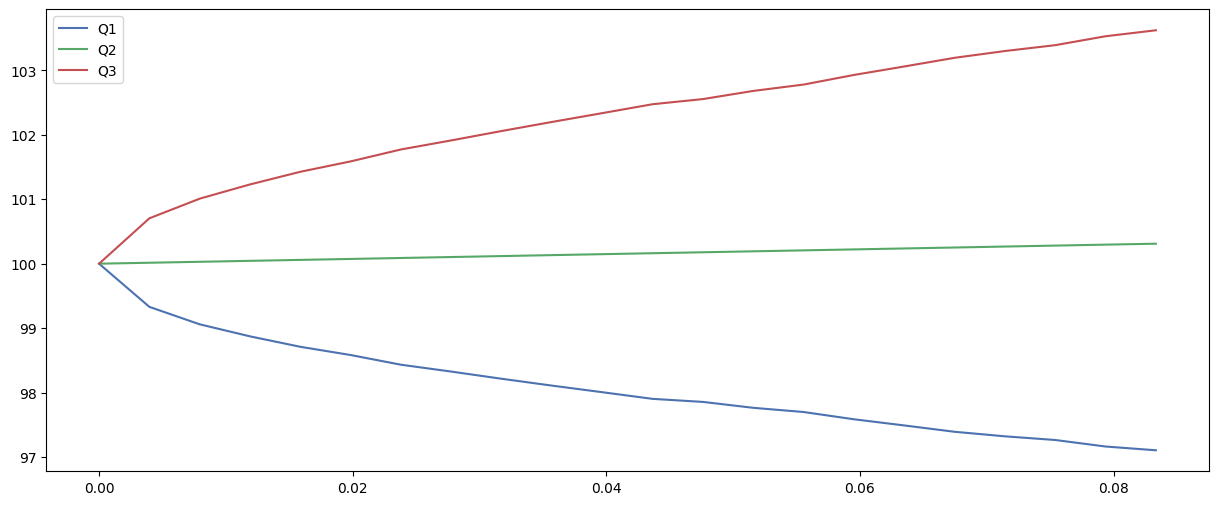

In [346]:
sigma_0 = 0.16
dt      = 1/252 # Every day, assuming 252 business days per year
n_days  = int(T/dt) 
n_sim   = 10000
shocks  = antithetic_normal(n_days, n_sim)
S_t     = simulate_underlying(S_0, r_f, 0.0, sigma_0, dt, shocks)

fig,ax  = plt.subplots(1,1,figsize=(15,6))
time_t  = np.arange(S_t.shape[0])*dt
stats   = pd.DataFrame(S_t.T).describe()
ax.plot(time_t, stats.T['25%'], label='Q1')
ax.plot(time_t, stats.T['50%'], label='Q2')
ax.plot(time_t, stats.T['75%'], label='Q3')
ax.legend();


Si les hypothèse BMS étaient effectivement respectées, quelle serait le prix des 6 puts 
d'intérêt pour une volatilité $\sigma_0$? Quelle est la différence $p_{mkt} - p_{bms}$? Que justifie cette différence selon vous?

In [347]:
p_bms = option_price(S = S_0, K = info['Strike'], r = r_f, y = 0, T = T, sigma = sigma_0 , is_call = False)
p_mkt = list(info['Put'])
diff  = pd.DataFrame(np.vstack([p_mkt, p_bms, p_mkt- p_bms]).T, columns=["p_mkt", "p_bms", "Diff"])


In [348]:
IV       = info["IV"][3]
K        = info['Strike'][3]
S_simul  = S_t.T[0]
t        = np.arange(0, T + dt, dt)
sigma    = np.sqrt((sigma_0 ** 2) + ((T - t) / T) * ((IV ** 2) - sigma_0 **2))

n_g1     = -1
delta_g1 = delta(S = S_simul, K = K, r = r_f, y = 0, T = T - t, sigma = sigma, is_call = False)
g_1      = option_price(S = S_simul, K = K, r = r_f, y = 0, T = T - t, sigma = sigma , is_call = False)
n_S      = -(n_g1 * delta_g1)
d_nS     = np.insert(np.diff(n_S), 0, n_S[0])


n_B_test2 = np.zeros(len(d_nS))
n_B_test2[0] = -(n_g1 * g_1[0] + d_nS[0] * S_simul[0])
n_B_test2[1:] = np.cumsum(-d_nS[1:] * S_simul[1:]) + n_B_test2[0]

n_B      = np.cumsum(-(n_g1 * g_1 + d_nS * S_simul))
n_B_2    = -(n_g1 * g_1 + n_S * S_simul)

interest_1 = np.zeros(len(n_B))
disc = (np.exp(dt * r_f) - 1)
for i, b in enumerate(n_B[:-1]):
    interest_1[i+1] = interest_1[i] *disc + b * disc

S_profit = np.insert(np.diff(S_simul) * n_S[:-1], 0, 0)
c_profit = np.insert(np.diff(n_g1 * g_1), 0, 0)

profits  = S_profit + c_profit + interest_1


pd.DataFrame(np.vstack([t,S_simul, g_1, n_S, d_nS, n_B, n_B_2,n_B_test2]).T, 
             columns=["t","S","g1","n_S","d_nS","n_B", "n_B_2", "Test (nb)"])

c:\Users\wdeli\Desktop\École\Maîtrise\Session 2\FINA 60206 - Produits dérivés\Devoir_1\utils.py:19: RuntimeWarning: divide by zero encountered in divide
  return (np.log(S/K) + (r - y + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))


,t,S,g1,n_S,d_nS,n_B,n_B_2,Test (nb)
0,0.0000,100.0000,3.3409,-0.6401,-0.6401,67.3520,67.3520,67.3520
1,0.0040,101.5377,2.3884,-0.5318,0.1083,58.7477,56.3911,56.3593
2,0.0079,101.8324,2.1804,-0.5120,0.0198,58.9117,54.3235,54.3430
3,0.0119,104.7086,0.9691,-0.2952,0.2168,37.1780,31.8821,31.6402
4,0.0159,106.4194,0.5132,-0.1847,0.1106,25.9244,20.1646,19.8734
5,0.0198,105.3679,0.6887,-0.2405,-0.0558,32.4918,26.0246,25.7521
6,0.0238,104.6290,0.8301,-0.2863,-0.0459,38.1241,30.7905,30.5543
7,0.0278,107.8168,0.2073,-0.0965,0.1898,17.8643,10.6134,10.0872
8,0.0317,107.5080,0.2067,-0.1001,-0.0036,18.4586,10.9707,10.4748
9,0.0357,107.8614,0.1459,-0.0776,0.0225,16.1799,8.5207,8.0502


In [349]:
# Initialisation des vecteurs de temps et du DF de profits
S_simul    = S_t.T
S_simul_df = pd.DataFrame(S_t.T)
t          = np.arange(0, T + dt, dt)
profit     = pd.DataFrame(np.zeros((n_sim, len(info))))

# Boucle pour itérer sur les différents puts
for j, _ in info.iterrows():
    
    # Données
    IV       = info["IV"][j]
    K        = info["Strike"][j]

    # Calcul de la prime et du delta du put
    delta_g1 = delta(S = S_simul, K = K, r = r_f, y = 0, T = T - t, sigma = sigma, is_call = False)
    g_1      = option_price(S = S_simul, K = K, r = r_f, y = 0, T = T - t, sigma = sigma , is_call = False)
    sigma    = np.sqrt((sigma_0 ** 2) + ((T - t) / T) * ((IV ** 2) - sigma_0 **2))

    # ASJ nécéssaire au delta hedging
    n_g1     = -1
    n_S      = pd.DataFrame(-(n_g1 * delta_g1))
    d_nS     = n_S.diff(axis = 1).fillna(n_S.iloc[0,0])

    # Calcul de la valeur du prêt
    n_B    = pd.DataFrame(np.zeros((len(n_S), len(t))))
    n_B[0] = -(n_g1 * g_1[0][0] + d_nS[0] * S_simul[0][0])
    n_B[n_B.columns[1:]] = (-d_nS[d_nS.columns[1:]] * S_simul_df[S_simul_df.columns[1:]]).cumsum(axis = 1) + n_B[0][0]

    # Calcul des profit sur l'ASJ
    S_simul_df   = pd.DataFrame(S_simul)
    temp         = S_simul_df.diff(axis = 1).dropna(axis = 1) 
    temp.columns = range(temp.columns.size)
    S_profit     = (temp * n_S[n_S.columns[:-1]]).sum(axis = 1)

    # Calcul des profit sur la position à couvrir
    c_profit     = pd.DataFrame(n_g1 * g_1).diff(axis = 1).sum(axis = 1) 

    # Calcul des profits d'intérêts
    interest = pd.DataFrame(np.zeros((len(n_B), len(t))))
    d_f      = np.exp(dt * r_f) - 1
    for i in range(len(t) - 1):
        interest[i+1] = (interest_1[i] + n_B[i]) * d_f

    int_profit = interest.sum(axis = 1)

    # Calcul des profits totaux
    profit[j]  =  S_profit + c_profit + int_profit



c:\Users\wdeli\Desktop\École\Maîtrise\Session 2\FINA 60206 - Produits dérivés\Devoir_1\utils.py:19: RuntimeWarning: divide by zero encountered in divide
  return (np.log(S/K) + (r - y + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
c:\Users\wdeli\Desktop\École\Maîtrise\Session 2\FINA 60206 - Produits dérivés\Devoir_1\utils.py:19: RuntimeWarning: divide by zero encountered in divide
  return (np.log(S/K) + (r - y + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
c:\Users\wdeli\Desktop\École\Maîtrise\Session 2\FINA 60206 - Produits dérivés\Devoir_1\utils.py:19: RuntimeWarning: divide by zero encountered in divide
  return (np.log(S/K) + (r - y + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
c:\Users\wdeli\Desktop\École\Maîtrise\Session 2\FINA 60206 - Produits dérivés\Devoir_1\utils.py:19: RuntimeWarning: divide by zero encountered in divide
  return (np.log(S/K) + (r - y + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
c:\Users\wdeli\Desktop\École\Maîtrise\Session 2\FINA 60206 - Produits dérivés\Devoir_1\utils.py:19: Runt

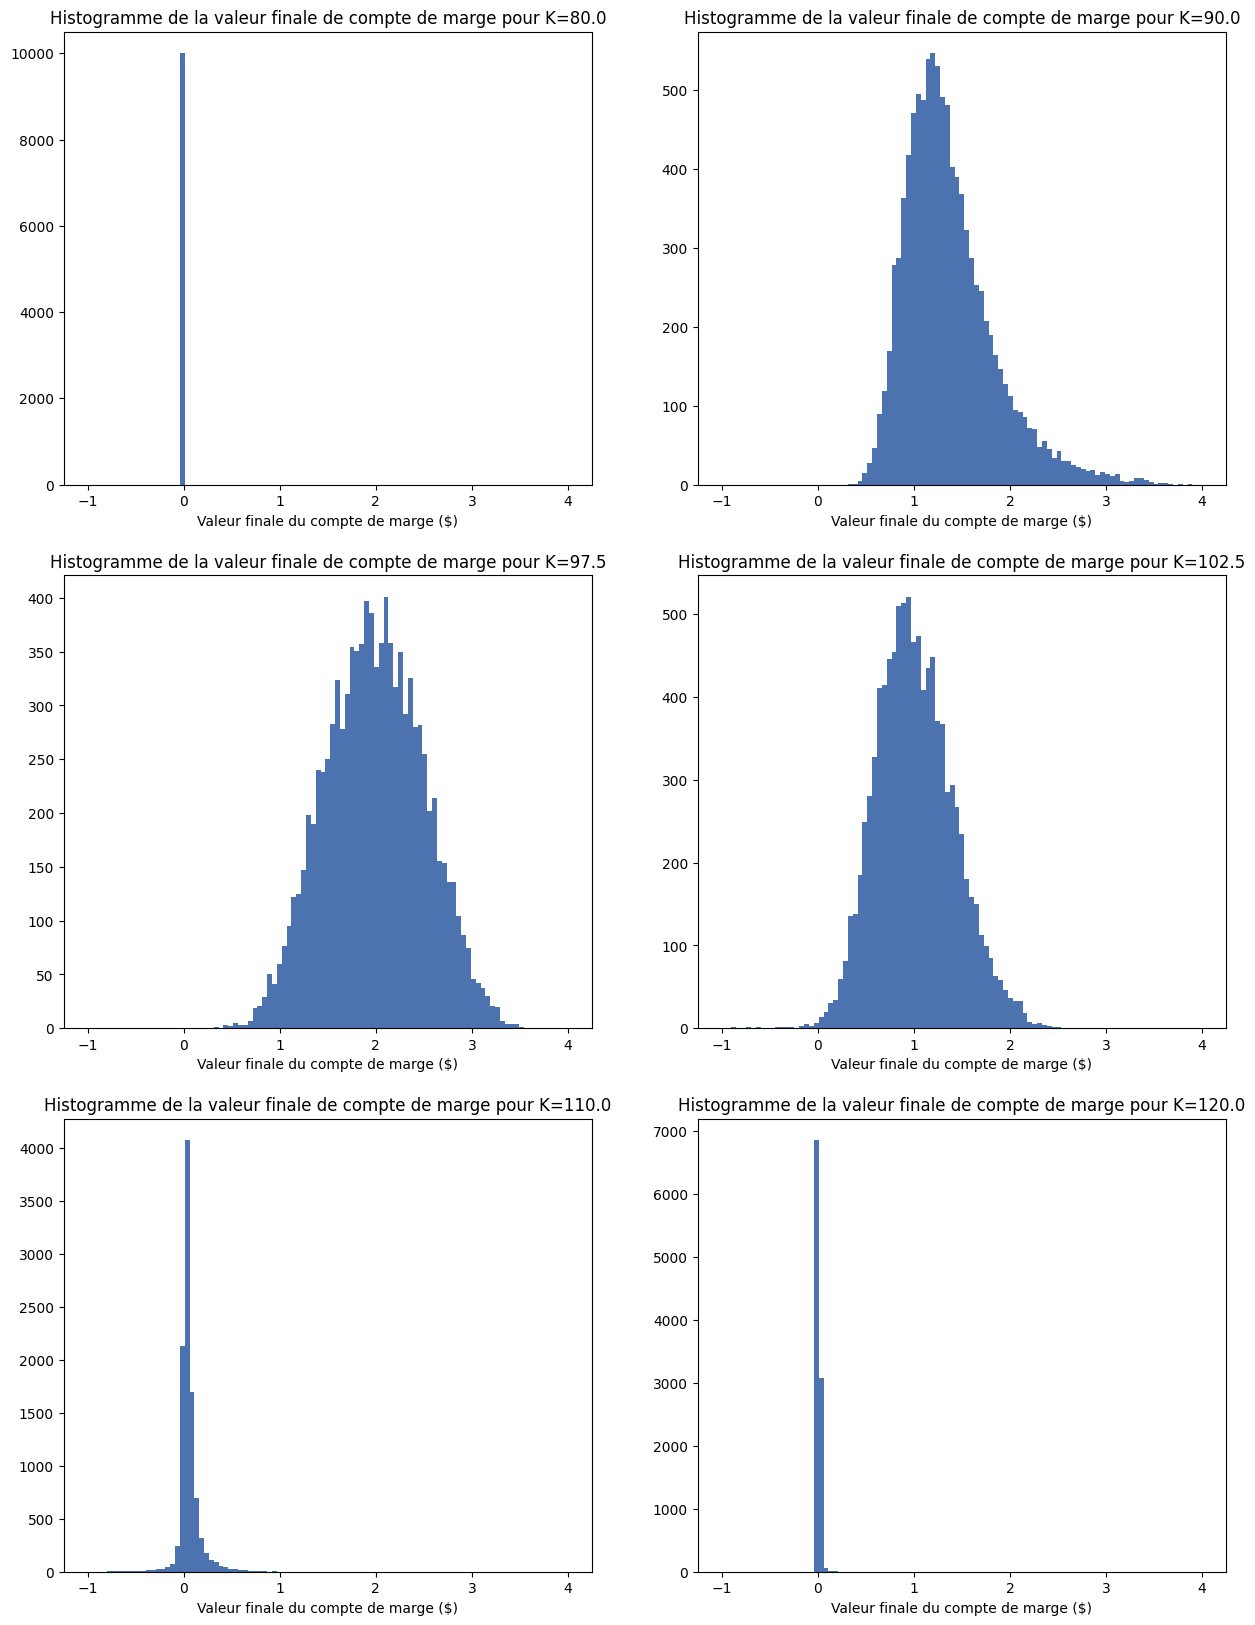

In [350]:
plt.style.use('seaborn-v0_8-deep')
figsize   = (15, 20)
fig, axes = plt.subplots(3, 2, figsize=figsize)
edges     = np.linspace(-1,4,100)

for i in range(3):
    for j in range(2):
        k = i * 2 + j 
        plt.sca(axes[i, j])
        plt.hist(profit[k], edges)
        plt.xlabel("Valeur finale du compte de marge ($)")
        plt.ylabel("")
        axes[i, j].yaxis.set_label_position("right")
        plt.title(
            f"Histogramme de la valeur finale de compte de marge pour K={info['Strike'].iloc[k]}")

Pour chacun des 6 puts européen mentionnés précédemment, vous souhaitez utiliser les simulations ci-haut afin d'évaluer une stratégie de delta-hedging, sous l'hypothèse que vous avez vendu le put en question (négliger le multiplicateur de 100 ici). À tous moment $t = n\Delta t$, vous calculerez le delta de chaque put en utilisant la $\sigma(t,K)$ définie comme suit:
\begin{equation*}
    \sigma^2(t,K) = \sigma_0^2 + \frac{T - t}{T} (IV^2(0,K) - \sigma_0^2)
\end{equation*}
Quelle hypothèse faites-vous, implicitement? Cette hypothèse est-elle raisonnable en pratique?

Produisez une sous-figure par strike (`fig, axes = plt.subplots(3, 2, figsize=(15,20))`), chacune rapportant l'histogramme de la valeur finale de votre compte de marge pour un put donné. Assurez-vous que tous les histogramme utilisent les mêmes intervalles, e.g., 

`
edges = np.linspace(-1.25,2.25,100)
...
ax.hist(M[-1,:], edges);
`

Discutez des résultats. En particulier, pourquoi la distribution ne semble-t-elle pas avoir une moyenne nulle?

Discutez (sans les implémentez) des modifications et nuances que vous devriez apporter à votre analyse si les puts étaient américains? Donnez suffisamment de détails, en vous référant au besoin à des lignes de votre code, pour que l'on saisisse bien les difficultés et limites de l'exercice.

In [351]:
toc()

Elapsed time: 41.870103 seconds.

